# Predicting Pop Mart’s Stock Price Based on Google Trends

Author: Sandy Xie

Course Project, UC Irvine, Math 10, Spring 25

I would like to post my notebook on the course's website. [Yes]

In [1]:
pip install yfinance

Note: you may need to restart the kernel to use updated packages.


# Introduction

Pop Mart, founded in 2010, is a Chinese designer toy company known for popularizing the “blind box” trend—sealed packages with randomly selected collectible figures. It collaborates with artists to produce popular series like Skullpanda, Molly, Dimoo, and Labubu, which are highly sought after by young consumers across Asia and globally.

In this project, I will analyze the impact of online search trends on Pop Mart’s stock price, and explore whether public interest on platforms like Google can help predict price movements. Using Google Trends data and historical stock prices from Yahoo Finance, I aim to understand how digital attention translates into real-world financial signals. 

# Data Description and Organization

In [2]:
import yfinance as yf
import pandas as pd

# Fetch Pop Mart stock data and clean it up
popmart = yf.Ticker("9992.HK")
df = popmart.history(period="6mo")  # last 6 months
df.index = df.index.date
df = df.drop(columns=['Dividends', 'Stock Splits'])
df['Weekday'] = pd.to_datetime(df.index).day_name()
df['Month'] = pd.to_datetime(df.index).month
print(df.head())

                 Open       High        Low      Close   Volume    Weekday  \
2024-12-12  91.324006  93.813755  91.324006  93.216217  6062628   Thursday   
2024-12-13  93.216222  94.610483  92.120734  92.568886  3588777     Friday   
2024-12-16  92.120734  95.954947  92.120734  94.859459  6251635     Monday   
2024-12-17  93.913355  96.502693  93.614582  93.813759  4706851    Tuesday   
2024-12-18  94.610480  94.809656  92.768066  94.311707  3240260  Wednesday   

            Month  
2024-12-12     12  
2024-12-13     12  
2024-12-16     12  
2024-12-17     12  
2024-12-18     12  


**The table below shows how data points are distributed across the days of the week.**

In [3]:
weekdays = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday"]

df[weekdays] = 0
for day in weekdays:
    df.loc[df["Weekday"] == day, day] = 1

weekday_counts = df[weekdays].sum(axis=0)
print(weekday_counts)

Monday       24
Tuesday      26
Wednesday    23
Thursday     24
Friday       23
dtype: int64


**I collected Google Trends data for keywords like "PopMart" over the past six months and combined it with daily stock prices for Pop Mart (9992.HK) to perform a regression analysis.**

In [4]:
trend_df = pd.read_csv("popmart_trends.csv", skiprows=2)
trend_df.columns = ["Date", "PopMartTrend"]
trend_df["Date"] = pd.to_datetime(trend_df["Date"]).dt.date
trend_df.set_index("Date", inplace=True)

merged_df = df.join(trend_df, how="inner")

# Preview merged data
print(merged_df.head())

                 Open       High        Low      Close   Volume    Weekday  \
2024-12-12  91.324006  93.813755  91.324006  93.216217  6062628   Thursday   
2024-12-13  93.216222  94.610483  92.120734  92.568886  3588777     Friday   
2024-12-16  92.120734  95.954947  92.120734  94.859459  6251635     Monday   
2024-12-17  93.913355  96.502693  93.614582  93.813759  4706851    Tuesday   
2024-12-18  94.610480  94.809656  92.768066  94.311707  3240260  Wednesday   

            Month  Monday  Tuesday  Wednesday  Thursday  Friday  PopMartTrend  
2024-12-12     12       0        0          0         1       0            16  
2024-12-13     12       0        0          0         0       1            16  
2024-12-16     12       1        0          0         0       0            14  
2024-12-17     12       0        1          0         0       0            16  
2024-12-18     12       0        0          1         0       0            16  


# Visualization

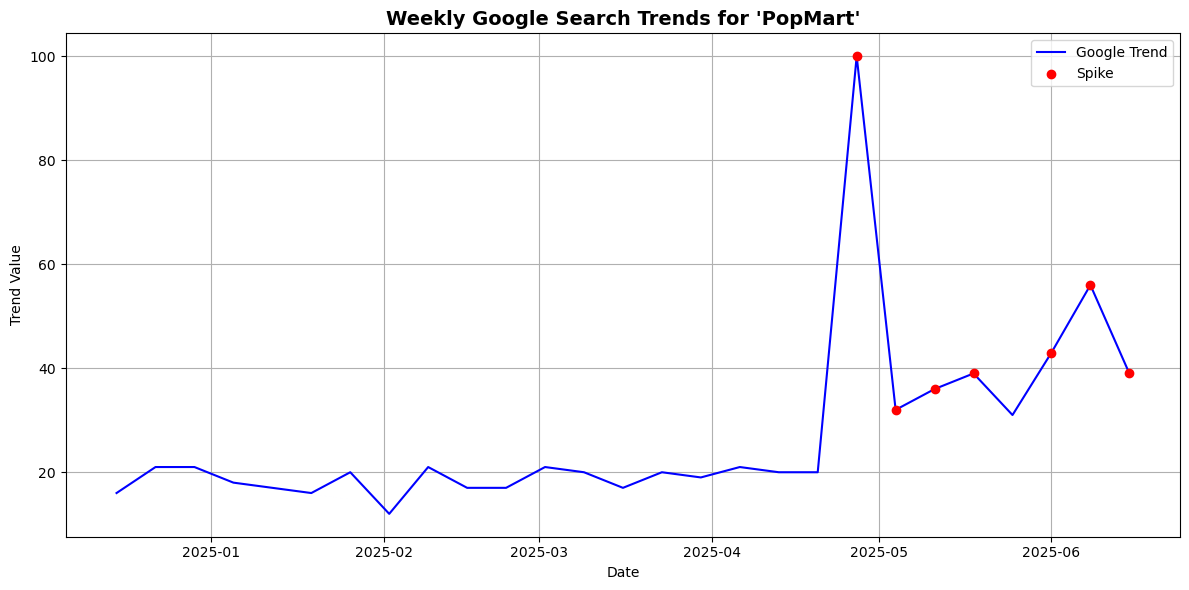

In [6]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Resample to weekly trends
merged_df.index = pd.to_datetime(merged_df.index)
weekly_trend = merged_df["PopMartTrend"].resample("W").last()

# Identify spikes (example: values greater than 75th percentile)
threshold = weekly_trend.quantile(0.75)  
spike_weeks = weekly_trend[weekly_trend > threshold]

# Plot the trend line
plt.figure(figsize=(12, 6))
plt.plot(weekly_trend.index, weekly_trend.values, label="Google Trend", color='blue')
plt.scatter(spike_weeks.index, spike_weeks.values, color='red', label='Spike', zorder=5)

# Step 4: Add titles and labels
plt.title("Weekly Google Search Trends for 'PopMart'", fontsize=14, weight='bold')
plt.xlabel("Date")
plt.ylabel("Trend Value")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Based on the graph, I observed several significant spikes in Google search interest for "PopMart," with one of the most dramatic occurring around late April. From what I know, April 25th coincides with the release of the highly anticipated "The Monsters: Big into Energy – Labubu" series. Given how popular Labubu figures are among collectors, it makes sense that this product launch would trigger a surge in online searches. This suggests that spikes in Google Trends are not random, but are often tied to major product drops or events.**

Smooth the data using a rolling average

In [7]:
def smooth_series(series, window=20):
    return series.rolling(window=window, center=True).mean()

Shift the trend data forward by 1 day (to simulate using search data to predict price)

In [8]:
shift_days = 1
smoothed_trend = smooth_series(merged_df["PopMartTrend"]).shift(shift_days)
smoothed_price = smooth_series(merged_df["Close"])

Normalize both series for visual comparison (centered around 0, range scaled)

In [9]:
def normalize(series):
    return (series - series.mean()) / series.std()

trend_normalized = normalize(smoothed_trend.dropna())
price_normalized = normalize(smoothed_price.dropna())

Align the two series

In [10]:
aligned_df = pd.DataFrame({
    "Trend": trend_normalized,
    "Price": price_normalized
}).dropna()

Plot the "PopMart" Google Trends and Stock Price Graph

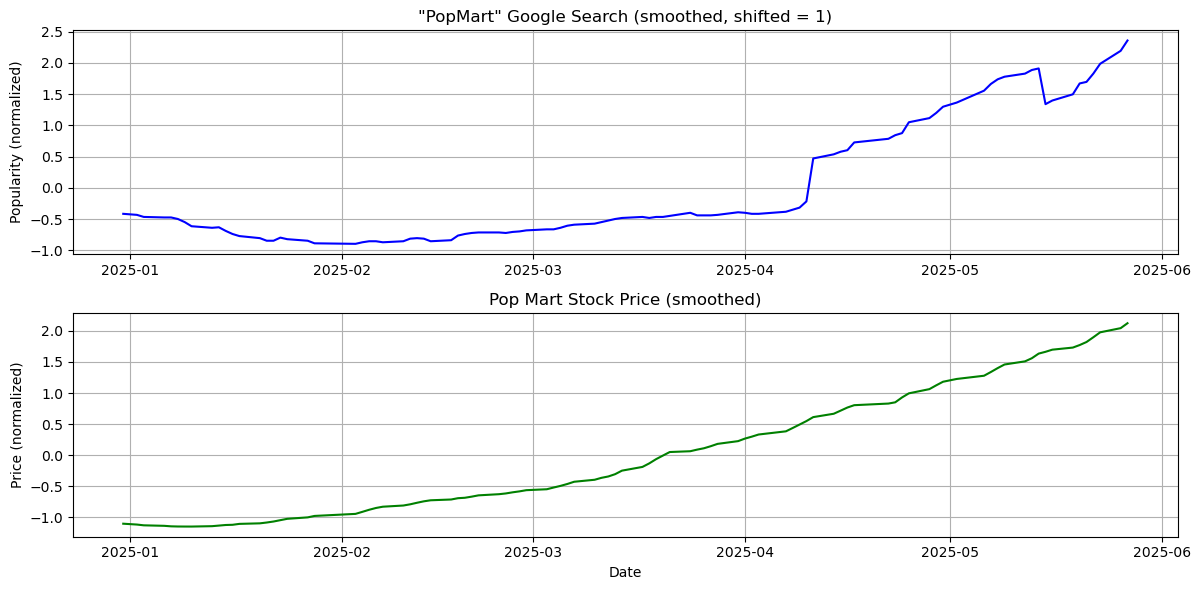

In [11]:
# Upper plot: "PopMart" Google Trends
plt.figure(figsize=(12, 6))
plt.subplot(2, 1, 1)
plt.plot(aligned_df.index, aligned_df["Trend"], label="PopMart Search Trend", color='blue')
plt.title('"PopMart" Google Search (smoothed, shifted = 1)')
plt.ylabel("Popularity (normalized)")
plt.grid(True)

# Bottom plot: Stock price
plt.subplot(2, 1, 2)
plt.plot(aligned_df.index, aligned_df["Price"], label="Pop Mart Stock Price", color='green')
plt.title("Pop Mart Stock Price (smoothed)")
plt.ylabel("Price (normalized)")
plt.xlabel("Date")
plt.grid(True)

plt.tight_layout()
plt.show()

Calculate the correlation between these two graph

In [12]:
correlation = aligned_df["Trend"].corr(aligned_df["Price"])
print(f"Correlation between Google Trend and Stock Price: {correlation:.3f}")

Correlation between Google Trend and Stock Price: 0.932


**A correlation of 0.932 indicates a very strong positive linear relationship between Google search interest for "PopMart" and the company’s stock price. This suggests that as search interest rises, the stock price tends to increase as well, and vice versa. The strength of this relationship implies that Google Trends may serve as a meaningful indicator of market sentiment or consumer demand for Pop Mart.**

Add clear labels and format the dates

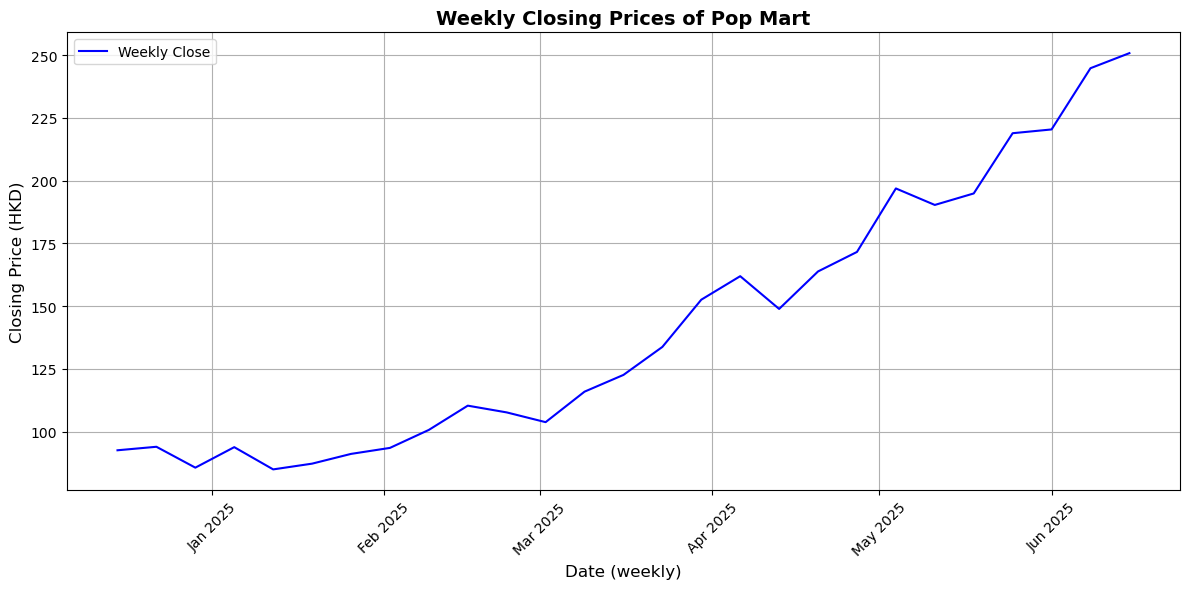

In [24]:
# Ensure datetime index
merged_df.index = pd.to_datetime(merged_df.index)

# Resample weekly closing price
weekly_prices = merged_df["Close"].resample("W").last()

# Plot
plt.figure(figsize=(12, 6))
plt.plot(weekly_prices.index, weekly_prices.values, label="Weekly Close", color="blue")

plt.title("Weekly Closing Prices of Pop Mart", fontsize=14, weight='bold')
plt.xlabel("Date (weekly)", fontsize=12)
plt.ylabel("Closing Price (HKD)", fontsize=12)

# Format dates on x-axis
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%b %Y'))
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()

**This graph shows a clear upward trend in Pop Mart’s weekly closing stock prices from December 2024 to June 2025. After stabilizing in late 2024 and early 2025, the stock steadily rose from February, with a marked acceleration in March. Its consistently positive trajectory, even with minor dips, indicates growing consumer demand. By late June 2025, the stock price had nearly tripled compared to its December levels, reflecting significant market momentum.**

#  Predicting Pop Mart’s Stock Price using Google Trends data, using regression models 

**To enhance the accuracy of our stock price prediction model, we incorporated the Exponential Moving Average (EMA) into our analysis. In the context of Pop Mart's stock, using the EMA helps us better capture the short-term market momentum. We calculated the 3-day EMA on the closing prices of Pop Mart to smooth out daily fluctuations and better identify the underlying trend.**

In [17]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, r2_score

Compute EMA from Close price

In [18]:
merged_df['EMA_3'] = merged_df['Close'].ewm(span=3, adjust=False).mean()

Use EMA, Google Trends, and Opening Price as features

In [19]:
df_sub = merged_df[['Close', 'Open', 'PopMartTrend', 'EMA_3']].dropna()
X = df_sub[['Open', 'PopMartTrend', 'EMA_3']]
y = df_sub['Close']

Train-test split

In [20]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

Fit linear regression model

In [21]:
reg = LinearRegression()
reg.fit(X_train, y_train)
y_pred = reg.predict(X_test)

Calculate the mean absolute error

In [25]:
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print("Mean Absolute Error:", mae)
print("R² Score:", r2)

Mean Absolute Error: 2.990450059497507
R² Score: 0.9634998006920182


Visualize the data

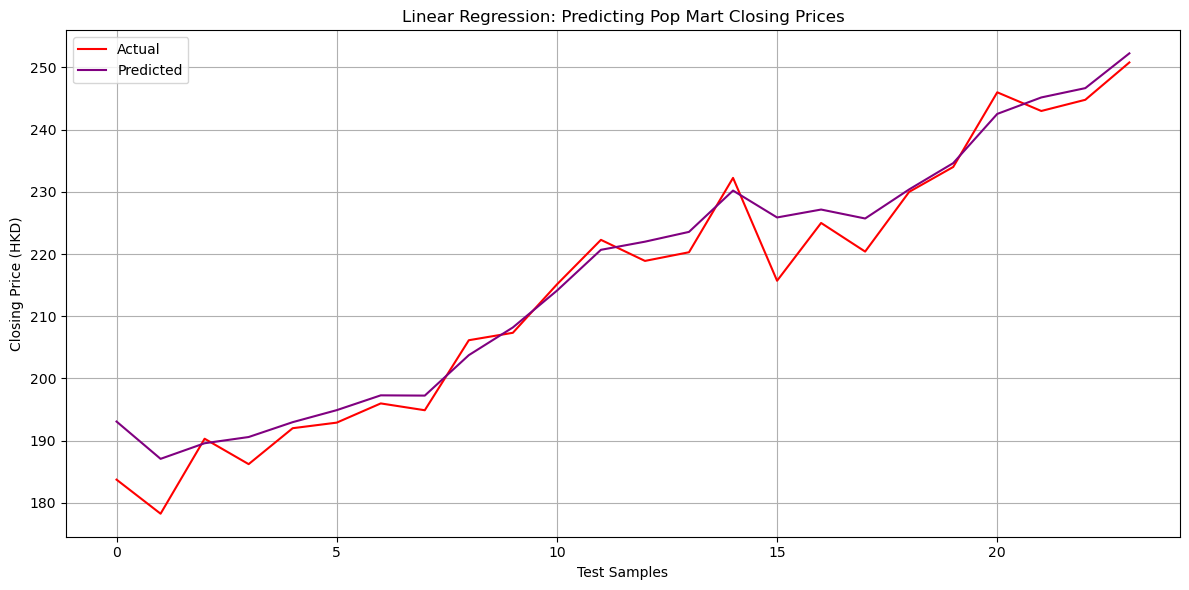

In [26]:
plt.figure(figsize=(12,6))
plt.plot(y_test.values, label="Actual", color="red")
plt.plot(y_pred, label="Predicted", color="purple")
plt.title("Linear Regression: Predicting Pop Mart Closing Prices")
plt.xlabel("Test Samples")
plt.ylabel("Closing Price (HKD)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Using Lagged Prices and Moving Averages for Predictions

**Lagged prices** are the stock's historical values over the past few days. These features capture momentum and immediate past trends. For example, a sudden dip or spike in the previous days often carries predictive power for near-future prices.

**Moving averages** are calculated over 5, 10, and 20-day windows, served as smoothing indicators that helped the model focus on broader trends rather than day-to-day fluctuations. They make it easier to detect the underlying trend.

In [ ]:
lag_days = [1, 2, 3]
for lag in lag_days:
    merged_df[f'Lag_{lag}_Close'] = merged_df['Close'].shift(lag)

moving_avg_days = [5, 10, 20]
for ma in moving_avg_days:
    merged_df[f'MA_{ma}'] = merged_df['Close'].rolling(window=ma).mean()

Also include the EMA from above

In [47]:
merged_df['EMA_3'] = merged_df['Close'].ewm(span=3, adjust=False).mean()

features = (
    [f'Lag_{lag}_Close' for lag in lag_days] +
    [f'MA_{ma}' for ma in moving_avg_days] +
    ['EMA_3', 'PopMartTrend']
)

processed_data = merged_df[features + ['Close']].dropna()

Create a visual tha compare close price, lagged prices, and moving averages

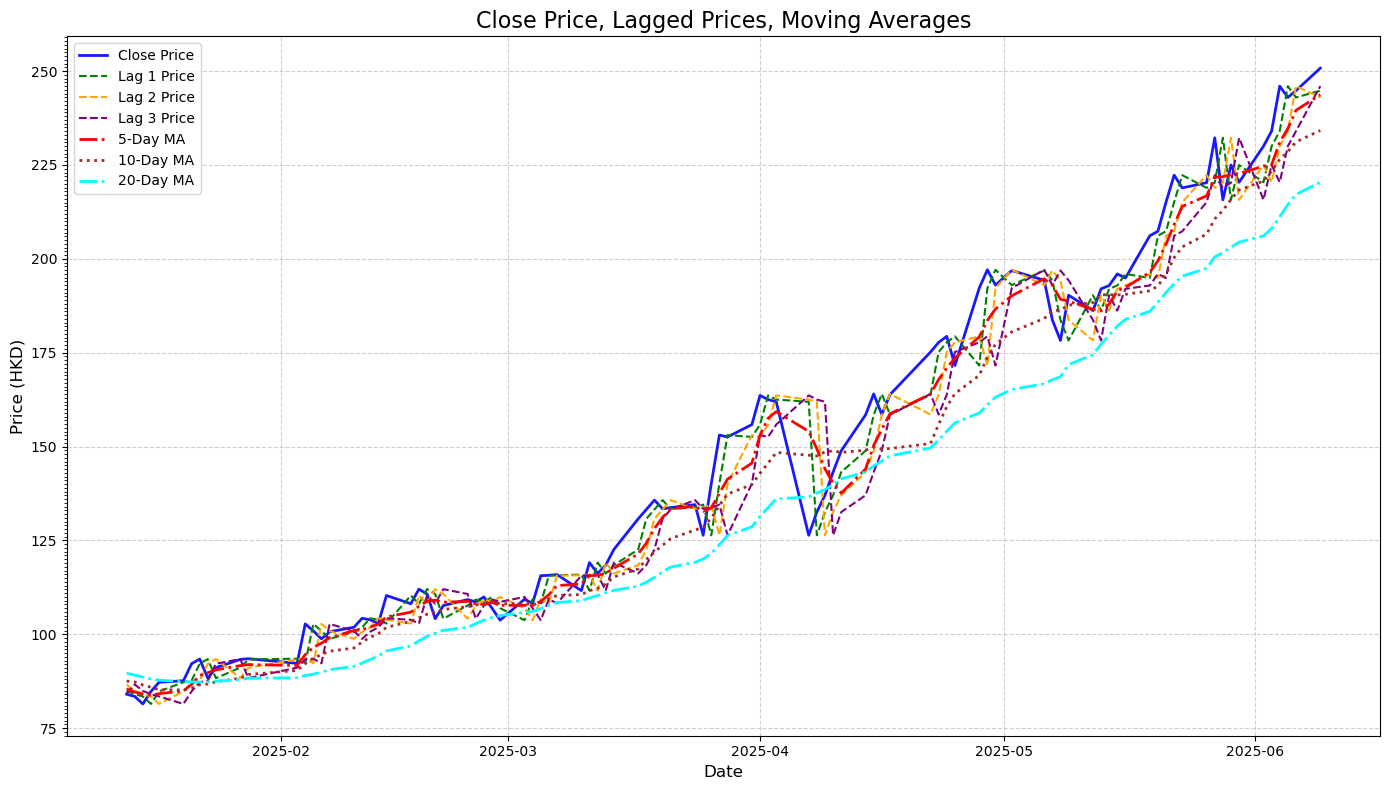

In [63]:
import matplotlib.ticker as mticker

plt.figure(figsize=(14, 8))

# Plot actual closing price
plt.plot(processed_data.index, processed_data['Close'],
         label='Close Price', color='blue', linewidth=2, alpha=0.9)

# Plot lagged prices
lag_colors = ['green', 'orange', 'purple']
for lag, color in zip([1, 2, 3], lag_colors):
    plt.plot(processed_data.index, processed_data[f'Lag_{lag}_Close'],
             label=f'Lag {lag} Price', linestyle='--', color=color, linewidth=1.5)

# Plot moving averages
ma_styles = ['-.', ':', '-.']
ma_colors = ['red', 'brown', 'cyan']
for ma, style, color in zip([5, 10, 20], ma_styles, ma_colors):
    plt.plot(processed_data.index, processed_data[f'MA_{ma}'],
             label=f'{ma}-Day MA', linestyle=style, color=color, linewidth=2)

# Final plot formatting
plt.title('Close Price, Lagged Prices, Moving Averages', fontsize=16)
plt.xlabel('Date', fontsize=12)
plt.ylabel('Price (HKD)', fontsize=12)
plt.legend(loc='upper left', fontsize=10)
plt.gca().yaxis.set_major_locator(mticker.AutoLocator())
plt.gca().yaxis.set_minor_locator(mticker.MultipleLocator(1))
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Using Linear Regression Model

Define feature and target values

In [64]:
from sklearn.model_selection import train_test_split

features = ['Lag_1_Close', 'Lag_2_Close', 'Lag_3_Close', 'MA_5', 'MA_10', 'MA_20', 'EMA_3', 'PopMartTrend']
target = 'Close'

Split into feature matrix X and target vector y

In [65]:
X = processed_data[features]
y = processed_data[target]

Train-test split and print data sizes

In [66]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

print("Training data size:", X_train.shape)
print("Testing data size:", X_test.shape)

Training data size: (78, 8)
Testing data size: (20, 8)


Use raise in conjunction with a conditional statement to ensure all required columns exist

In [67]:
if not all(col in processed_data.columns for col in features + [target]):
    raise ValueError("Some required columns are missing in the dataset.")

Prepare feature matrix (X) and target vector (y)

In [68]:
X = processed_data[features].dropna().to_numpy()
y = processed_data[target].dropna().to_numpy().ravel()

Split data into training and testing sets (80% train, 20% test)

In [69]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

Train the Linear Regression model and display coefficients

In [70]:
model = LinearRegression()
model.fit(X_train, y_train)

coefficients = pd.DataFrame({
    'Feature': features,
    'Coefficient': model.coef_
})

print("Linear Regression Coefficients:")
print(coefficients)

Linear Regression Coefficients:
        Feature  Coefficient
0   Lag_1_Close    -0.456576
1   Lag_2_Close    -0.189789
2   Lag_3_Close    -0.053455
3          MA_5    -0.357131
4         MA_10    -0.121174
5         MA_20     0.009436
6         EMA_3     2.168981
7  PopMartTrend    -0.002819


Calculate the evaluation results

In [71]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

y_pred = model.predict(X_test)

mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Mean Squared Error (MSE): {mse:.4f}")
print(f"R-squared (R²): {r2:.4f}")

Mean Absolute Error (MAE): 0.1460
Mean Squared Error (MSE): 0.0336
R-squared (R²): 0.9999


Visualization for comparison

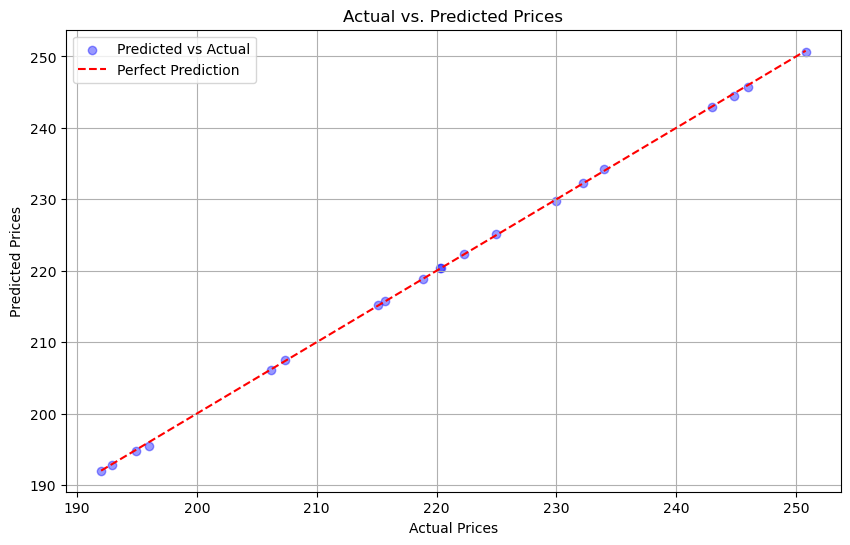

In [72]:
plt.figure(figsize=(10, 6))

plt.scatter(y_test, y_pred, alpha=0.4, color='blue', label='Predicted vs Actual')

plt.plot([min(y_test), max(y_test)], [min(y_test), max(y_test)], color='red', linestyle='--', label='Perfect Prediction')

plt.xlabel('Actual Prices')
plt.ylabel('Predicted Prices')
plt.title('Actual vs. Predicted Prices')
plt.legend()
plt.grid(True)
plt.show()

# Using Decision Tree Regressor

In [73]:
dt_model = DecisionTreeRegressor(
    max_depth=3,         
    min_samples_split=5, 
    min_samples_leaf=3, 
    random_state=42
)

In [74]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Create and train model
dt_model = DecisionTreeRegressor(max_depth=3, random_state=42)
dt_model.fit(X_train, y_train)

# Predict
y_pred = dt_model.predict(X_test)

# Evaluate
mae = mean_absolute_error(y_test, y_pred)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Decision Tree MAE: {mae:.4f}")
print(f"Decision Tree MSE: {mse:.4f}")
print(f"Decision Tree R² : {r2:.4f}")

Decision Tree MAE: 30.1646
Decision Tree MSE: 1227.9711
Decision Tree R² : -2.8607


**In my observation here, the Decision Tree model performed significantly worse than the Linear Regression model. From the line graphs previously, my closing price data shows a smooth and steady upward trend. This kind of trend is well-suited for linear models like Linear Regression. On the other hand, Decision models rely on sharp splits that don't align well with smooth financial data. Because my dataset is relatively small, the Decision Tree may create splits that are too specific and fail to generalize well to new or unseen data.**

# Summary

In this project, I explored whether Google search trends can help predict Pop Mart’s stock price. By merging search interest data for the keyword “PopMart” with historical stock prices from Yahoo Finance, I created a dataset to analyze the relationship between public interest and market behavior. I engineered features like lagged closing prices and moving averages to reflect past market patterns, and tested various models—Linear Regression, Random Forest, and Decision Tree Regressor—to evaluate their prediction accuracy. Overall, my findings suggest that digital attention, as measured by Google Trends, combined with historical pricing features, can be a useful tool in forecasting Pop Mart’s stock movement. 

# References

- What is the source of your dataset(s)?
    - [Pop Mart's Stock Price is From Yahoo Finance](https://finance.yahoo.com/quote/9992.HK/)
    - [Google Trends Data](https://trends.google.com/trends/explore?date=2024-12-09%202025-06-09&q=popmart&hl=en)
- Were any portions of the code or ideas taken from another source? List those sources here and say how they were used.
    - [Linear Regression from Lecture Notes](https://rayzhangzirui.github.io/math10sp24/notes/linear_regression.html)
    - The comparison graph is inspired by this research paper: https://www.ccom.ucsd.edu/~cdeotte/papers/GoogleTrends.pdf
    - [Netflix Stock Price Prediction](https://christopherdavisuci.github.io/UCI-Math-10-W22/Proj/StudentProjects/JiayuWang.html) to calculate EMA
    - [TQQQ Stock Predictor Project](https://rayzhangzirui.github.io/math10fa24/final_projects/James_Cho.html) utilizing Lagged Prices
    - [Decision Tree Regression](https://www.geeksforgeeks.org/python-decision-tree-regression-using-sklearn/)